In [ ]:
%load_ext autoreload
%autoreload 2

# Discrete Diffusion

By this point, we are familiar with continuous diffusion (e.g. on images). Given a sequence of values $x_0 \in \R^L$ as our clean signal (e.g. the flattened pixels of an image)

![](figures/continuous_diffusion.png)

### $q$: Forward (noising) process
We define a sequence of noise levels $\{\alpha_t\}_{t=1}^T$, each $0 < \alpha_t < 1$,
The noising process adds incrementally more noise to the signal 
$$
  q(x_t \mid x_{t-1})
  = \mathcal{N}\bigl(x_t;\,\sqrt{\alpha_t}\,x_{t-1},\,(1-\alpha_t)\,I\bigr).
$$
In practice, we can sample generate the noised sample at any $t$ directly with
$$
  q(x_t \mid x_0)
  = \mathcal{N}\bigl(x_t;\,\sqrt{\bar\alpha_t}\,x_0,\,(1-\bar\alpha_t)\,I\bigr),
  \quad
  \bar\alpha_t := \prod_{s=1}^t \alpha_s.
$$

### $p_\theta$: Learned reverse (denoising) process
We train a neural network $\epsilon_\theta(x_t, t)$ to recover the uncorrupted signal

![](figures/ddpm_ddim.png)
  

**DDPM (Ho et al., 2020)**: Model predicts added noise at each increment
- Model output: 
  $$
    \epsilon_\theta(x_t, t) \;\approx\;\text{the true noise \(\epsilon\) in }x_t
  $$
- Reverse step:
  $$
    p_\theta(x_{t-1}\mid x_t)
    = \mathcal{N}\bigl(x_{t-1};\,\mu_\theta(x_t,t),\,\sigma_t^2 I\bigr),
  $$
  where one common choice is
  $$
    \mu_\theta(x_t,t)
    = \frac{1}{\sqrt{\alpha_t}}
      \Bigl(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}}
      \,\epsilon_\theta(x_t,t)\Bigr), \\

    \sigma_t^2 = \beta_t = 1-\alpha_t \qquad \text{(the forward variance)}
  $$


**DDIM (Song et al., 2021)**: Model predicts fully de-noised image. Deterministic model
$$
  x_{t-1}
  = \sqrt{\bar\alpha_{t-1}}\underbrace{
    \;\frac{x_t - \sqrt{1-\bar\alpha_t}\,\epsilon_\theta(x_t,t)}
        {\sqrt{\bar\alpha_t}}}_{\text{predicted $x_0$}}
  \;+\;\sqrt{1-\bar\alpha_{t-1}}\,\underbrace{
    \epsilon_\theta(x_t,t)}_{\text{“noise” term}}.
$$


🤯 **Key question: how do we add noise to discrete data?**

# Masked Diffusion Language Model
Sahoo et al., 2024

In [2]:
import hydra
import torch
import diffusion
import dataloader

import pprint
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/huangf2/miniforge3/envs/mdlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoModelForMaskedLM

overrides=[
    'mode=sample_eval',
    'eval.checkpoint_path=kuleshov-group/mdlm-owt',
    'data=openwebtext-split',
    'model.length=1024',
    'sampling.predictor=ddpm_cache',
    'sampling.steps=1000',
    'loader.eval_batch_size=1',
    'sampling.num_sample_batches=1',
    'backbone=hf_dit'
]
with hydra.initialize(version_base=None, config_path='configs'):
    config = hydra.compose(config_name='config', overrides=overrides)
    sar_config = hydra.compose(config_name='config', overrides=overrides)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
    
tokenizer = dataloader.get_tokenizer(config)

model_name = 'kuleshov-group/mdlm-owt'
model = AutoModelForMaskedLM.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
def generate_samples(config, tokenizer):
    model = diffusion.Diffusion(config, tokenizer=tokenizer, device=device).to(device)
    if config.eval.disable_ema:
        model.ema = None
    samples = model.restore_model_and_sample(
        num_steps=config.sampling.steps,
    )   
    text_samples = model.tokenizer.batch_decode(
        samples, 
        skip_special_tokens=False, 
        clean_up_tokenization_spaces=False
    )[0]

    return text_samples

In [8]:
text_samples = generate_samples(config, tokenizer)

print('#' * 80)
pprint.pp(text_samples)
print('#' * 80)

################################################################################
['<|endoftext|>’s something which has become lost most in jazz in the world to '
 'begin with. I’m also a jazz preacher, and in New Orleans I had an '
 'influential jazz group. Yet until now, there’t any of these artists and '
 'musicians, so I found myself an evangelist position. Nearly all the idea in '
 'these last six years now was so to learn about something as opposed to just '
 'push a little further with the artists and experimentation a little further '
 'which is positive. But it’s attracted a different audiences. It’s different, '
 'something appealable and different.\n'
 '\n'
 'That’s something you speak to more in English rather than of music. Did you '
 'to see if something new about jazz may still be left at the homeschool side '
 'of mainstream education?\n'
 '\n'
 'I want a lesson that doesn’t have that same jazz audience. I struggle with '
 'jazz because I want something to maybe slide ba

### How it works

![](figures/mdlm.png)

**Diffusion Loss:**
$$
\mathbb{E}_q \left[
\underbrace{-\log p_\theta(\mathbf{x} \mid \mathbf{z}_{t(0)})}_{\mathcal{L}_{\text{recons}}}
+ 
\underbrace{
\sum_{i=1}^T D_{\text{KL}}\left[
q(\mathbf{z}_{s(i)} \mid \mathbf{z}_{t(i)}, \mathbf{x}) 
\parallel 
p_\theta(\mathbf{z}_{s(i)} \mid \mathbf{z}_{t(i)})
\right]
}_{\mathcal{L}_{\text{diffusion}}}
\right]
+ 
\underbrace{
D_{\text{KL}}\left[
q(\mathbf{z}_{t(T)} \mid \mathbf{x}) 
\parallel 
p_\theta(\mathbf{z}_{t(T)})
\right]
}_{\mathcal{L}_{\text{prior}}}
$$


**MDLM Loss (single token):**
$$
\mathcal{L}_{\text{diffusion}} = 
\sum_{i=1}^T \mathbb{E}_q \left[
D_{\text{KL}}\left(
q(\mathbf{z}_{s(i)} \mid \mathbf{z}_{t(i)}, \mathbf{x}) \,\|\, 
p_\theta(\mathbf{z}_{s(i)} \mid \mathbf{z}_{t(i)})
\right)
\right]
= 
\sum_{i=1}^T \mathbb{E}_q \left[
\frac{\alpha_{t(i)} - \alpha_{s(i)}}{1 - \alpha_{t(i)}} 
\log \langle \mathbf{x}_\theta(\mathbf{z}_{t(i)}), \mathbf{x} \rangle
\right]
$$


**MDLM Loss (sequence of tokens):**

We apply forward noising process (masking) independently across the sequence, and denoise each token independently conditioned on the latent $p_\theta(z_s^{1:L}|z_t^{1:L}) = \prod_{l=1}^L p_\theta(z_s^l|z_t^{1:L})$

$$
\mathcal{L}^{\infty}_{\text{NELBO}} = 
\mathbb{E}_q \int_{t=0}^{t=1} 
\frac{\alpha_t'}{1 - \alpha_t}
\sum_{\ell} \log \langle \mathbf{x}_\theta^\ell(\mathbf{z}_t^{1:L}, t), \mathbf{x}^\ell \rangle \, \mathrm{d}t
$$

Note that this is a *weighted average of masked languge modeling loss*!

### Generation Trace

❓ What is the quality of the text?


👍 clear theme

👍 grammatically correct sentences (mostly)

👎 lacks coherence across sentences and paragraphs

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

def generate_trajectory(config, tokenizer, step=100):
    """
    Visualize text diffusion generation process
    
    Args:
        config: Model configuration
        tokenizer: Tokenizer for decoding
        step: Step interval for visualization
    """
    model = diffusion.Diffusion(config, tokenizer=tokenizer, device=device).to(device)
    if config.eval.disable_ema:
        model.ema = None
    samples, ts = model.restore_model_and_sample(
        num_steps=config.sampling.steps,
        store_traj=True
    )
    
    # Prepare data for visualization
    timesteps = []
    pad_ratios = []
    token_sequences = []  # Added for position tracking
    
    for i in range(0, len(samples), step):
        # Store token sequence for position tracking
        token_sequences.append(samples[i])
        
        # Calculate mask ratio (assuming mask token is in vocabulary)
        pad_token_id = tokenizer.pad_token_id if hasattr(tokenizer, 'pad_token_id') else None
        if pad_token_id is not None:
            pad_count = (samples[i] == pad_token_id).sum().item()
            pad_ratio = pad_count / samples[i].shape[-1]
        else:
            pad_ratio = 0
        
        timesteps.append(ts[i].item())
        pad_ratios.append(pad_ratio)

    #Write trajectory to a formatted text file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"output/0_text_traj_{timestamp}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("=" * 100 + "\n")
        f.write("TEXT DIFFUSION GENERATION TRAJECTORY\n")
        f.write(f"Generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total steps: {len(timesteps)}\n")
        f.write("=" * 100 + "\n\n")
        
        # Add token-aligned section
        f.write("-" * 100 + "\n")
        f.write("Pos: " + "".join(f"{i:>7}" for i in range(token_sequences[0].shape[-1])) + "\n")
        for i, (timestep, pad_ratio, tokens) in enumerate(zip(timesteps, pad_ratios, token_sequences)):
            f.write(f"t{timestep:.2f}: ")
            for j in range(tokens.shape[-1]):
                token_text = tokenizer.decode([tokens.flatten()[j]], skip_special_tokens=False).replace('\n', ' ').replace('[PAD]', '[.]')
                token_text = token_text[:7]
                f.write(f"{token_text:>7}")
            f.write("\n")
        f.write("\n")
        
        final_text_sample = model.tokenizer.batch_decode(
            samples[-1], 
            skip_special_tokens=False, 
            clean_up_tokenization_spaces=True
        )[0].replace('\n', '  ')
        f.write("Final Text Sample:\n")
        f.write(final_text_sample + "\n")
        
        
    print(f"Trajectory saved to: {filename}")
    

    # Plot 1: Mask ratio over time
    plt.plot(timesteps, pad_ratios, 'b-o', linewidth=2, markersize=4)
    plt.plot([0, 1], [0, 1], color='red')
    plt.xlabel('Diffusion Time')
    plt.ylabel('Mask Token Ratio')
    plt.title('Demasking Progress Over Diffusion Time')
    plt.grid(True, alpha=0.3)
    plt.show()

Trajectory saved to: output/0_text_traj_20250722_163323.txt


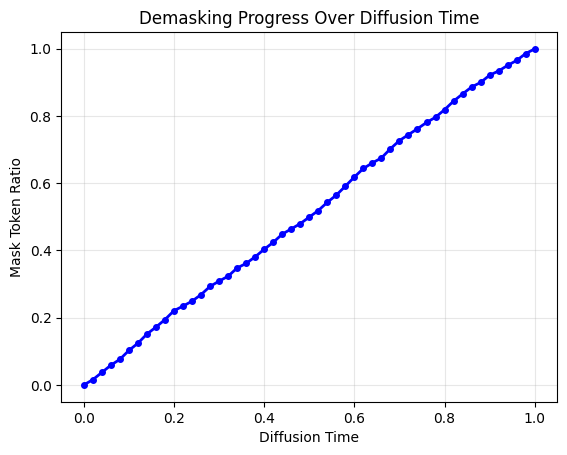

In [ ]:
# For plot visualization only
generate_trajectory(config, tokenizer, step=20)

💡 De-masking can occur at any location. Once a token is de-masked, the model has to deal with it. 

v.s. 

Autoregressive models can leverage full leftward context to make coherent passages.

# Discrete Diffusion

**D3PM (Austin et al., 2021)**

![](figures/d3pm_noise.png)

Let $x$: a scalar discrete random variable with $K$ categories be represented by a one-hot column vector, and the set of these vectors be 
$\mathcal{V} \in \set{ x \in \set{0,1}^K: \sum_{i=1}^K x_i = 1}$


Then, a discrete diffusion process on $x$ can be represented by a $K \times K$ transition matrix $Q_t$, $$[Q_t]_{ij} = q(x_t = j | x_{t-1} = i)$$


Among many possibilities, a few ways to design this transition matrix includes:
1. Gaussian: For ordinal categories, we can write down a Gaussian analogue
    $$
        [Q_t]_{ij} =
        \begin{cases}
        \displaystyle
        \frac{
            \exp\left( -\frac{4 |i - j|^2}{(K - 1)^2 \beta_t} \right)
        }{
            \sum\limits_{n = -(K - 1)}^{K - 1} \exp\left( -\frac{4 n^2}{(K - 1)^2 \beta_t} \right)
        } & \text{if } i \ne j \\[16pt]
        1 - \sum\limits_{\substack{l = 0 \\ l \ne i}}^{K - 1} [Q_t]_{il} & \text{if } i = j
        \end{cases}
    $$

*Unfortunately, interesting discrete data like text have no natural ordinal relations*

2. Uniform: $\beta_t$ probability for uniformly transitioning to a non-self category
    $$
        [Q_t]_{ij} = 
        \begin{cases}
        1 - \frac{K-1}{K} \beta_t & \text{if } i = j \\
        \frac{1}{K} \beta_t & \text{if } i \ne j
        \end{cases}
    $$
3. Absorbing: $\beta_t$ probability of transitioning to an absorbing state $m$. Once absorbed, stays absorbed. *Similar to BERT*
    $$
        [Q_t]_{ij} =
        \begin{cases}
        1 & \text{if } i = j = m \\
        1 - \beta_t & \text{if } i = j \ne m \\
        \beta_t & \text{if } j = m,\, i \ne m
        \end{cases}
    $$



💡 **INSIGHT 1: Absorbing transitions work better**

![](figures/d3p_masked.png)


💡 **INSIGHT 2: Imposing ordinal relation between text tokens doesn't help**

Note: Transition probabilities derived from KNN graph, constructed using token similarity on pre-trained text embedding.


![](figures/d3pm_metrics.png)